## Compressed Sensing

In this notebook, we will take a closer look at a technique for sparse identification called **compressed sensing**.

Compressed sensing deals with reconstructing a signal from far fewer samples than are traditionally necessary.
The signal may be a timeseries, an image, even a fluid mechanical flow field or many other things.
In some sense it is the inverse of a compression algorithm, where a large computer file is deflated to only contain the bits and patterns necessary to recreate the file somewhere else.
In compressed sensing we don't already know the "way it was compressed", but we nonetheless try to decompress it.

Traditionally, signal reconstruction is bound by the Shannon-Nyquist sampling theorem.
If samples are taken at regular intervals, our sampling rate must be twice that of the highest frequency we want to reconstruct.
But is it possible to do better?

If the signal we're dealing with is _sparse_ (or compressible), the answer to this is _yes_.

## What is a sparse signal


In [Brunton&Kutz], they say that:

> Most natural signals, such as images or audio. are highly compressible.
> This compressibility means that, when the signal is written in an appropriate basis, only a few modes are active,
> thus reducing the number of values that must be stored for an accurate representation.

What is important in this definition is the notion of "an appropriate basis".
Sparsity means that the sparse signal is a combination of just a small number of these basis signals, and if we have an idea what these basis signals are, we just have to do a little work to figure out which of them are active.

One example of a sparse signal is a pure sine-wave.
If $x(t) = \sin(t)$, then a Fourier transform of $x$ would yield a single spike at $\omega = 1$.
Here, the appropriate basis is sines and cosines with different frequencies and a sparse representation of the signal could be a vector where all elements are zero, except the element which corresponds to $\omega = 1$.

In more mathematical terms, if $x \in \mathbb{R}^n$ is our signal (corresponding perhaps to $x_i = x(t_i)$) and we have a matrix $\Psi \in \mathbb{R}^{n\times n}$ where each column is a vector in the appropriate basis, then we can write

$$
x = \Psi s
$$

where $s \in \mathbb{R}^n$ is a sparse vector containing mostly zeros.

The trick with compressed sensing is to figure out which elements in the sparse vector $s$ should be non-zero (and what their amplitude is), when we only know a few measurements of the high-resolution signal $x$.
Let's take $y \in \mathbb{R}^m$ to be the few measurements we take (that is $m < n$).

Vectors:
- $x$: "true", high-dimensional signal, $\mathbb{R}^n$
- $s$: sparse vector, the true signal wrt. the generic basis, $\mathbb{R}^n$
- $y$: measurement, $\mathbb{R}^m$

Linear transformations:
- $\Psi$: modes in the generic basis, $\Psi: \mathbb{R}^n \to \mathbb{R}^n$
- $C$: measurement matrix, $C: \mathbb{R}^n \to \mathbb{R}^m$

$$
x = \Psi s, y = Cx
$$

So, if we had $s$, we could get $x$ by multiplying by $\Psi$
and we could recover $y$ by measuring with $C$.
As a chain of transformations:

$$
s \mapsto_\Psi x \mapsto_C y
$$

However, we have $y$, but want to know $x$.
We achieve this by "using $y$ to find $s$", thereby making a cyclic graph.
But how can we _actually_ do that?
We formulate a minimization problem where the appropriate $s$ is the global minimizer.

## Compressed sensing

Using the concepts in the lectures, we introduce the following notation in the context of compressed sensing:

- $x \in \mathbb{R}^n$ is the high-resolution signal
- $s \in \mathbb{R}^n$ is the sparse vector representing the signal
- $y \in \mathbb{R}^m$ is the vector of measurements with $m < n$

Also:

- $\Psi: \mathbb{R}^n \to \mathbb{R}^n$ is the matrix holding the modes in the generic basis
  - This is an `n x n` matrix
- $C: \mathbb{R}^n \to \mathbb{R}^m$ is the measurmement matrix which maps $x$ to $y$
  - This is an `n x m` matrix

This means we can set up the following equation relating the sparse vecotr $s$ to $y$:

$$
y = C \Psi s
$$

since $x = \Psi s$ and $y = Cx$.

In [1]:
import numpy as np
import imageio.v3 as iio
import scipy.fftpack as spfft
import matplotlib.pyplot as plt
import scipy.optimize as spopt

## L1 vs. L2 fitting: an example

In [2]:
# generate some data with noise
x = np.sort(np.random.uniform(0, 10, 15))
y = 3 + 0.2 * x + 0.1 * np.random.randn(len(x))

# find L1 line fit
l1_fit = lambda x0, x, y: np.sum(np.abs(x0[0] * x + x0[1] - y))
xopt1 = spopt.fmin(func=l1_fit, x0=[1, 1], args=(x, y))

# find L2 line fit
l2_fit = lambda x0, x, y: np.sum(np.power(x0[0] * x + x0[1] - y, 2))
xopt2 = spopt.fmin(func=l2_fit, x0=[1, 1], args=(x, y))

Optimization terminated successfully.
         Current function value: 0.595829
         Iterations: 69
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 0.040574
         Iterations: 55
         Function evaluations: 102


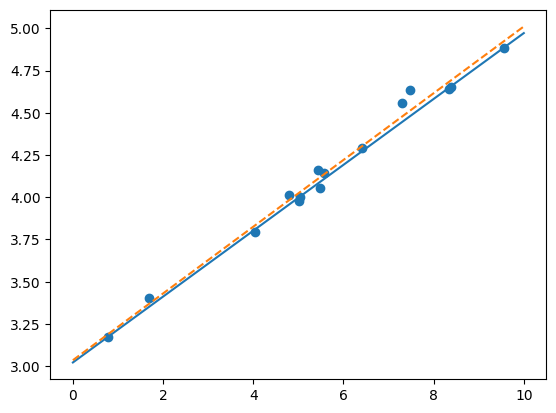

In [3]:
f = lambda opt, x: opt[1] + opt[0] * x
xs = np.linspace(0, 10)
plt.plot(xs, f(xopt1, xs))
plt.plot(xs, f(xopt2, xs), linestyle="--")
plt.scatter(x, y)

In [4]:
# adjust data by adding outlyers
y2 = y.copy()
y2[3] += 4
y2[13] -= 3

# refit the lines
xopt12 = spopt.fmin(func=l1_fit, x0=[1, 1], args=(x, y2))
xopt22 = spopt.fmin(func=l2_fit, x0=[1, 1], args=(x, y2))

Optimization terminated successfully.
         Current function value: 7.593627
         Iterations: 54
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: 23.730233
         Iterations: 65
         Function evaluations: 122


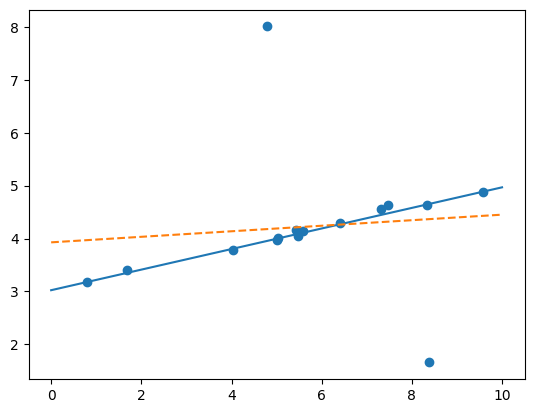

In [5]:
f = lambda opt, x: opt[1] + opt[0] * x
xs = np.linspace(0, 10)
plt.plot(xs, f(xopt12, xs))
plt.plot(xs, f(xopt22, xs), linestyle="--")
plt.scatter(x, y2)

## What does sparsity actually look like?



In [6]:
from scipy.optimize import minimize

n, p = 1000, 200
Theta = np.random.randn(p, n)
y = np.random.randn(p)

l1_norm = lambda x: np.linalg.norm(x, ord=1)
eq_constr = lambda s: Theta @ s - y
constr = ({"type": "eq", "fun": eq_constr})

x0 = np.linalg.pinv(Theta) @ y
res = minimize(l1_norm, x0, method="SLSQP", constraints=constr)
s_l1 = res.x
s_l2 = x0

(-0.05, 0.05)

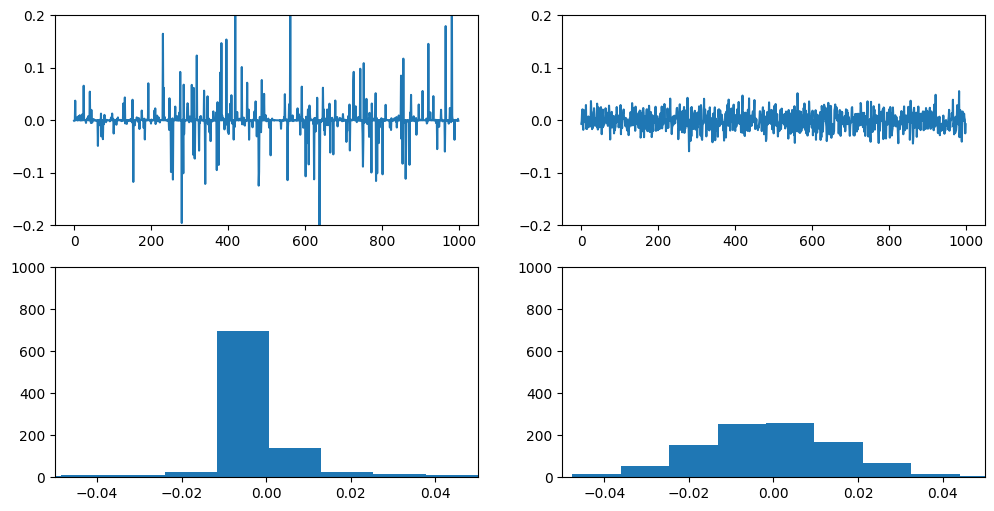

In [7]:
plt.figure(figsize=(12,6))

plt.subplot(2, 2, 1); plt.plot(s_l1); plt.ylim(-.2, .2)
plt.subplot(2, 2, 2); plt.plot(s_l2); plt.ylim(-.2, .2)
plt.subplot(2, 2, 3); plt.hist(s_l1, bins=40); plt.ylim(0, 1000); plt.xlim(-.05, .05)
plt.subplot(2, 2, 4); plt.hist(s_l2, bins=10); plt.ylim(0, 1000); plt.xlim(-.05, .05)

Since the system was randomly generated, the approximate solution should look noisy.
The main point to take away is that:
- the $l^2$ solution favors having many active coefficients while giving them small amplitudes
- the $l^1$ solution favors fewer active coefficients (more than 700 seem to _be zero_) while giving each active coefficient a larger amplitude

## Formulation as optimization problems

### Zero-norm optimization problem
$$
\hat{s} = \argmin_s \|s\|_0 \quad \text{subject to}\quad y = C \Psi s
$$

Remark:
- This formulation is non-convex due to the nature of the "zero-norm" (it is in fact not a norm)

### One-norm, noise free problem
$$
\hat{s} = \argmin_s \|s\|_1 \quad \text{subject to}\quad y = C \Psi s
$$

Remark:
- This problem _is_ convex
- However, it does not deal with noise
- Admissible reformulation given certain conditions on the measurement matrix $C$

### One-norm, noise robust
$$
\hat{s} = \argmin_s \|s\|_1 \quad \text{subject to}\quad \|y - C \Psi s\|_2^2 < \epsilon
$$

Remark:
- This problem is _also_ convex
- Robust to a noise level of $\epsilon$
- Related to a relaxed convex optimization problem

### Relaxed one-norm problem, noise robust
$$
\hat{s} = \argmin_s \|y - C \Psi s\|_2^2 + \lambda \|s\|_1
$$

Remark:
- $\lambda \geq 0$ weights the importance of the sparsity
- $\lambda = 0$ recovers the least squares approximation to the problem, which we know is prone to _not_ being sparse
- Must strike a balance between 2-norm which activates more modes and 1-norm which tries to deactivate them
- Too high $\lambda$ might yield poor results, possibly since the error tolerance is not modeled explicitly, but bound with the sparsity of the solution

In [8]:
# Define Discrete Cosine Transform (DCT) and its inverse
def dct2(x):
    return spfft.dct(spfft.dct(x, axis=0, norm='ortho'), axis=1, norm='ortho')

def idct2(x):
    return spfft.idct(spfft.idct(x, axis=0, norm='ortho'), axis=1, norm='ortho')

We're solving the optimization problem

$$
s^* = \argmin_s \|As - b\|_2^2 + \lambda \|s\|_1
$$

Since the $l^1$-norm doesn't have a derivative, we cannot use any method.
There's a nifty Python library that implements an algoritm called OWL-QN,
which is a quasi-Newton method that has the $l^1$-norm baked in.
It minimizes functions on the form

$$
f(x) = g(x) + \lambda \|x\|_1
$$

where we only need to specify $g(x)$ and the gradient $\nabla g(x)$.
This means we don't have to deal with the $l^1$-regularization term and
can focus on the equality constraint we turned into a noisy inequality constraint.
In our problem, we have that

$$
g(x) = \|Ax - b\|_2^2
$$

And so, the gradient is

$$
\nabla g(x) = 2 A^T \left( Ax - b\right)
$$

Our matrix $A$ is still the composition of the basis transform and the sampling matrix.
If we computed the entire matrix and stored it in memory, if would take a lot of memory.
For an image of size 1600 x 1000, if we sample 10% of the data, the $A$-matrix would be 1.6 million by 160 thousand.
This is roughly equivalent to 950 GiB of we're using 32 bit floats.
But if we're clever, we can write a function that returns $g(x)$ and $\nabla g(x)$ that avoids explicitly forming the $A$-matrix.
This is called a matrix-free approach.

So, the basis transformation $\Psi$ is simply the discrete cosine transform.
We've already defined functions that perform both the DCT and the inverse DCT on a 2-tensor, also known to us as an image.
Also, the sampling matrix simply selects $m$ of the elements of a vector.
The inverse transform would be to put these elements back in a larger vector in the positions they came from.
Armed with this, we can write the matrix-free evaluation function for the optimization problem.

In [19]:
def make_evaluation_function(nx, ny, ri, b):
    """Wraps the OWL-QN evaluation function in an explicit environment with necessary constant arguments well-defined."""
    def evaluate_flattened(x, g_gradient):
        """Objective function for L1-optimization."""

        x2 = x.reshape((nx, ny)).T  # Prepare x for 2D DCT, it is given as a long vector
        Ax2 = idct2(x2)             # Applying inverse DCT matrix-free
        Ax = Ax2.T.flat[ri].reshape(b.shape)  # Applying sampling matrix by the random index ri

        # Calculate residual Ax-b and its 2-norm squared
        Axb = Ax - b
        gx = np.sum(Axb**2)

        # Project residual onto a blank image, matrix-free "inversion" of sampling matrix
        Axb2 = np.zeros(x2.shape)
        Axb2.T.flat[ri] = Axb  # Fill columns-first

        # Compute gradient
        AtAxb2 = 2 * dct2(Axb2)  # Applying DCT as the final step to fully apply A^T
        _g_gradient = AtAxb2.T.reshape(x.shape)  # Stack columns
        np.copyto(g_gradient, _g_gradient)

        return gx
    return evaluate_flattened

In [20]:
should_log = 1
if should_log > 1:
    def owl_qn_progress_callback(x, g, fx, xnorm, gnorm, step, k, num_eval, *args):
        # print(f"xnorm: {xnorm:.3e}, gnorm: {gnorm:.3e}, iterations: {k}, evals: {num_eval}")
        if k%10 == 0: print(f"Iteration {k}: took {num_eval} evaluations to get gradient {gnorm:.3e}, total loss is {fx:.3e}.")
        return None
else:
    def owl_qn_progress_callback(x, g, fx, xnorm, gnorm, step, k, num_eval, *args):
        return None

First, we try to see what happens if we simply use a least-squares minimization.
We can do this by using `minimize` from `scipy.optimize`.

In [21]:
from lbfgs import fmin_lbfgs

Xorig = iio.imread('image.jpg', pilmode='L')
ny, nx = Xorig.shape

sample_sizes = (0.1, 0.01)
Z_l2 = [np.zeros(Xorig.shape, dtype='uint8') for _ in sample_sizes]
masks_l2 = [np.zeros(Xorig.shape, dtype='uint8') for _ in sample_sizes]

for i, s in enumerate(sample_sizes):
    k = round(nx * ny * s)
    ri = np.random.choice(nx * ny, k, replace=False)  # Random sample indices
    if should_log > 0: print(f"i: {i}, sample: {s}, k: {k}, ri: {ri.shape}")

    X = Xorig.squeeze()
    
    Xm = 255 * np.ones(X.shape)
    Xm.T.flat[ri] = X.T.flat[ri]
    masks_l2[i] = Xm
    
    b = X.T.flat[ri].astype(float)
    eval_fnc = make_evaluation_function(nx, ny, ri, b)

    Xat2 = fmin_lbfgs(eval_fnc, np.zeros((nx,ny)), owl_qn_progress_callback, orthantwise_c=0.0, line_search="wolfe")
    Xat = Xat2.reshape(nx, ny).T
    Xa = idct2(Xat)

    Xa = np.clip((Xa - Xa.min()) / (Xa.max() - Xa.min()) * 255, 0, 255) 

    Z_l2[i] = Xa.astype('uint8')

i: 0, sample: 0.1, k: 56300, ri: (56300,)
i: 1, sample: 0.01, k: 5630, ri: (5630,)


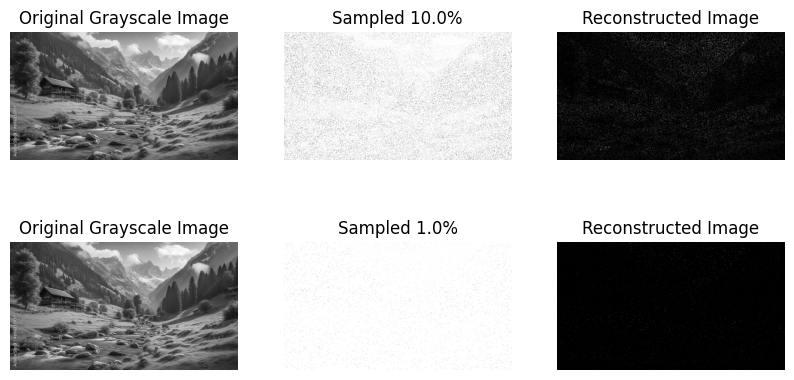

In [22]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 3, 1); plt.imshow(Xorig, cmap='gray'); plt.title('Original Grayscale Image'); plt.axis('off')
plt.subplot(2, 3, 2); plt.imshow(masks_l2[0], cmap='gray'); plt.title(f'Sampled {sample_sizes[0]*100:.1f}%'); plt.axis('off')
plt.subplot(2, 3, 3); plt.imshow(Z_l2[0], cmap='gray'); plt.title('Reconstructed Image'); plt.axis('off')
plt.subplot(2, 3, 4); plt.imshow(Xorig, cmap='gray'); plt.title('Original Grayscale Image'); plt.axis('off')
plt.subplot(2, 3, 5); plt.imshow(masks_l2[1], cmap='gray'); plt.title(f'Sampled {sample_sizes[1]*100:.1f}%'); plt.axis('off')
plt.subplot(2, 3, 6); plt.imshow(Z_l2[1], cmap='gray'); plt.title('Reconstructed Image'); plt.axis('off')
plt.show()

## With L^1 regularization this time

In [23]:
Xorig = iio.imread("image.jpg", pilmode="L")
ny, nx = Xorig.shape

sample_sizes = (.1, .01)
Z_l1 = [np.zeros(Xorig.shape, dtype='uint8') for s in sample_sizes]
masks_l1 = [np.zeros(Xorig.shape, dtype='uint8') for s in sample_sizes]

for i,s in enumerate(sample_sizes):
    k = round(nx * ny * s)
    ri = np.random.choice(nx * ny, k, replace=False)
    if should_log > 0: print(f"i: {i}, sample: {s}, k: {k}, ri: {ri.shape}")
    
    X = Xorig[:,:].squeeze()
    
    Xm = 255 * np.ones(X.shape)
    Xm.T.flat[ri] = X.T.flat[ri]
    masks_l1[i][:,:] = Xm
    
    b = X.T.flat[ri].astype(float)
    eval_fnc = make_evaluation_function(nx, ny, ri, b)
    
    Xat2 = fmin_lbfgs(eval_fnc, np.zeros((nx,ny)), owl_qn_progress_callback, orthantwise_c=1.0, line_search="wolfe")
    Xat = Xat2.reshape(nx, ny).T
    Xa = idct2(Xat)

    Xa = np.clip((Xa - Xa.min()) / (Xa.max() - Xa.min()) * 255, 0, 255)
    
    Z_l1[i][:,:] = Xa.astype('uint8')

i: 0, sample: 0.1, k: 56300, ri: (56300,)
i: 1, sample: 0.01, k: 5630, ri: (5630,)


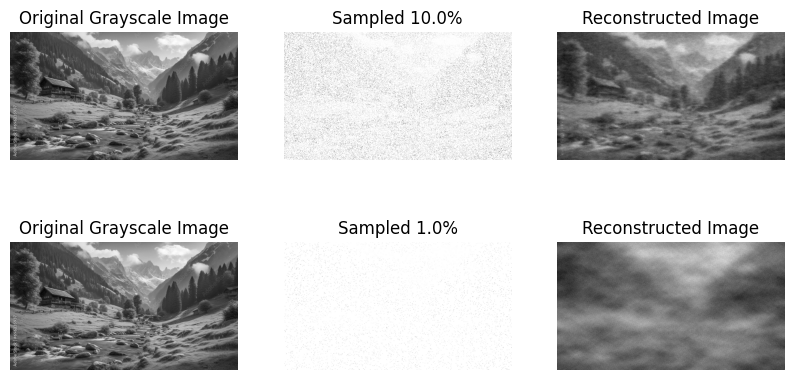

In [24]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 3, 1); plt.imshow(Xorig, cmap='gray'); plt.title('Original Grayscale Image'); plt.axis('off')
plt.subplot(2, 3, 2); plt.imshow(masks_l1[0], cmap='gray'); plt.title(f'Sampled {sample_sizes[0]*100:.1f}%'); plt.axis('off')
plt.subplot(2, 3, 3); plt.imshow(Z_l1[0], cmap='gray'); plt.title('Reconstructed Image'); plt.axis('off')
plt.subplot(2, 3, 4); plt.imshow(Xorig, cmap='gray'); plt.title('Original Grayscale Image'); plt.axis('off')
plt.subplot(2, 3, 5); plt.imshow(masks_l1[1], cmap='gray'); plt.title(f'Sampled {sample_sizes[1]*100:.1f}%'); plt.axis('off')
plt.subplot(2, 3, 6); plt.imshow(Z_l1[1], cmap='gray'); plt.title('Reconstructed Image'); plt.axis('off')
plt.show()